# Análisis de resultados

El experimento fué realizado en un servidor de Oracle Cloud el 27 de julio del 2025 a las 3:55am (GMT-5). Debido a que es un servidor que en el día responde a solicitudes de Internet, se eligió esta hora en particular para realizar el experimento ya que es cuando el servidor recibe muy poco tráfico.

El servidor cuenta con 4 núcleos habilitados de un procesador Ampere Altra A1, de arquitectura ARM. 24GB de memoria RAM y SO _Ubuntu 24.04.2 LTS_, corriendo el kernel `6.8.0-1028-oracle`. Las versiones de los lenguajes de programación usadas en el experimento son `Python 3.12.11` y `Lua 5.4.6`

Para el análisis de resultados se optó en primera instancia por el uso de gráficas que describan los datos en los que tenemos interés, para esto se usaron las librerías `matplotlib`, `pandas` y `seaborn`.

El tiempo de ejecución para Python fue de 5h 37min 10s y el de Lua 39min 36s. De modo que Python fué aproximadamente 8.52 veces más lento en comparación.

Los grafos de tipo `geometric` y `gnp_dense` se limitaron hasta 14 vértices, debido a tiempos extremadamente largos de ejecución (20+ horas) con grafos más grandes como se ve en la siguiente imagen:

![](images/time_n20.jpeg)

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [23]:
python_csv = '../results/python/repeated_results.csv'
lua_csv = '../results/lua/repeated_experiment_results.csv'

df_python = pd.read_csv(python_csv)
df_lua = pd.read_csv(lua_csv)

df_python['language'] = 'Python'
df_lua['language'] = 'Lua'

# Unir ambos en un solo dataframe para análisis combinado
df = pd.concat([df_python, df_lua], ignore_index=True)

# Filtrar solo soluciones exitosas (opcional)
df_success = df[df['path_found'] == 1]

## Estadistica descriptiva
En la siguiente tabla se pueden ver la media y la mediana de los 3 algoritmos implementados en ambos lenguajes sobre el conjunto de grafos que se usó para el experimento.

In [19]:
def calcular_estadisticas(df, lenguaje='Python'):
  stats = df.groupby(['algorithm', 'graph_type',
                      'size_n'])[['time_seconds', 'cost']].agg(
                          time_mean=('time_seconds', 'mean'),
                          time_median=('time_seconds', 'median'),
                          time_std=('time_seconds', 'std'),
                          cost_mean=('cost', 'mean'),
                          cost_median=('cost', 'median'),
                          cost_std=('cost', 'std'),
                      ).reset_index()
  stats['language'] = lenguaje
  return stats


python_stats = calcular_estadisticas(df_python, lenguaje='Python')
lua_stats = calcular_estadisticas(df_lua, lenguaje='Lua')


In [20]:
tabla_comparativa = pd.concat([python_stats, lua_stats], ignore_index=True)
tabla_comparativa

,algorithm,graph_type,size_n,time_mean,time_median,time_std,cost_mean,cost_median,cost_std,language
0,Backtracking,geometric,5,0.000046,0.000046,6.109404e-06,-1.0000,-1.0000,0.0,Python
1,Backtracking,geometric,8,0.008637,0.008637,1.988455e-05,2.4517,2.4517,0.0,Python
2,Backtracking,geometric,10,0.009180,0.009180,6.143344e-05,3.2026,3.2026,0.0,Python
3,Backtracking,geometric,12,0.034394,0.034394,2.990510e-04,-1.0000,-1.0000,0.0,Python
4,Backtracking,geometric,14,1703.478384,1703.478384,1.543482e+02,3.0509,3.0509,0.0,Python
...,...,...,...,...,...,...,...,...,...,...
163,NearestNeighbor,pathological,14,0.000024,0.000024,2.121320e-06,-1.0000,-1.0000,0.0,Lua
164,NearestNeighbor,pathological,15,0.000025,0.000025,7.071068e-07,15.0000,15.0000,0.0,Lua
165,NearestNeighbor,pathological,16,0.000026,0.000026,1.414214e-06,-1.0000,-1.0000,0.0,Lua
166,NearestNeighbor,pathological,18,0.000027,0.000027,7.071068e-07,-1.0000,-1.0000,0.0,Lua


## Gráfico tamaño de grafo vs tiempo

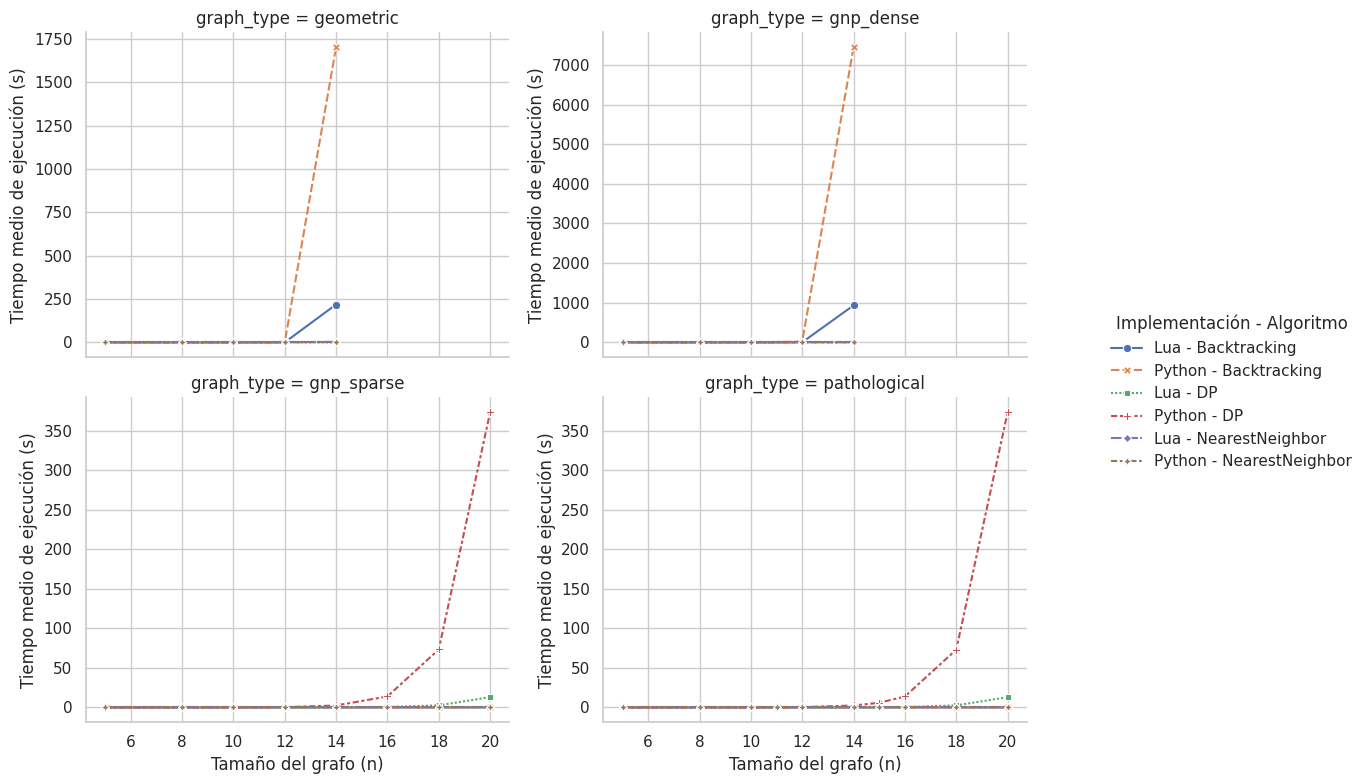

In [5]:
# Agrupar y calcular media y desviación estándar por grupo
grouped = df.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                     ]).agg(mean_time=('time_seconds', 'mean'),
                            std_time=('time_seconds', 'std')).reset_index()

# Crear columna combinada para distinguir en la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Configurar estilo
sns.set(style="whitegrid")

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar gráfico por subgráfico
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_time',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Ajustar etiquetas
for ax in g.axes.flat:
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Tiempo medio de ejecución (s)')

# Ajustar leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 1. Gráfico tamaño de grafo vs tiempo (escala normal)*

1. Rendimiento general por algoritmo:

* Vecino Más Cercano:
  El algoritmo del Vecino Más Cercano (Nearest Neighbor), tanto en Lua como en Python, mantiene un tiempo de ejecución prácticamente constante a medida que aumenta el tamaño del grafo en todos los tipos de grafos analizados. Esto indica que presenta el mejor rendimiento en términos de eficiencia temporal, con una escalabilidad favorable incluso para grafos grandes. No obstante, se debe recordar que este algoritmo no garantiza soluciones óptimas, sino aproximadas.

* Programación Dinámica:
  La Programación Dinámica (DP), implementada en Python y Lua, evidencia una tendencia exponencial en el tiempo de ejecución, particularmente notable a partir de $n \approx 16$ en grafos tipo `gnp_sparse` y `pathological`. Este comportamiento es consistente con la complejidad del algoritmo $O(n²·2ⁿ)$, lo que lo hace poco adecuado para grafos de tamaño grande. En grafos `gnp_dense` y `geometric`, su ejecución no se representa plenamente debido a limitaciones de tiempo o recursos.

* Backtracking:
  El algoritmo de Backtracking muestra el peor desempeño en términos de tiempo de ejecución, especialmente en Python. En grafos del tipo `geometric` y `gnp_dense`, los tiempos alcanzan valores extremadamente altos (por ejemplo, superiores a 1700 segundos y 7000 segundos respectivamente), haciendo inviable su uso práctico para grafos mayores a $n = 14$. La implementación en Lua muestra un rendimiento más contenido, pero igualmente limitado a grafos pequeños.

2. Comportamiento específico por tipo de grafo:

* `geometric`:
  Se observa un crecimiento abrupto en el tiempo de ejecución del algoritmo de Backtracking en Python a partir de $n = 14$. Programación Dinámica y Vecino Más Cercano mantienen tiempos aceptables. Esta estructura de grafo parece amplificar el costo computacional de las búsquedas exhaustivas.

* `gnp_dense`:
  Este tipo de grafo es particularmente adverso para Backtracking y DP, donde los tiempos se disparan. Esto se puede atribuir a la elevada conectividad, que incrementa exponencialmente el número de caminos posibles a explorar. Los resultados respaldan la necesidad de evitar algoritmos exhaustivos en contextos densos.

* `gnp_sparse`:
  A pesar de la menor densidad de conexiones, Programación Dinámica presenta una curva ascendente notable a partir de $n = 16$, lo que confirma su crecimiento exponencial. Aquí, los algoritmos heurísticos como Vecino Más Cercano muestran su ventaja comparativa.

* `pathological`:
  Este tipo de grafo también resulta desafiante para DP, con un incremento sostenido en el tiempo de ejecución en Python. El patrón de crecimiento sugiere que este tipo de grafo exacerba los casos límite del algoritmo. El rendimiento estable de Vecino Más Cercano reafirma su aplicabilidad práctica en escenarios adversos.

3. Lenguaje de implementación:

* Python vs Lua:
  Las implementaciones en Lua muestran tiempos de ejecución más contenidos que sus contrapartes en Python, especialmente en Backtracking. Esto puede atribuirse a diferencias en la eficiencia del runtime de cada lenguaje, en la gestión de memoria, o en el grado de optimización del código base. Sin embargo, para algoritmos de baja complejidad como Vecino Más Cercano, estas diferencias son menos significativas.

4. Observaciones adicionales:

* La escalabilidad del algoritmo del Vecino Más Cercano lo posiciona como el candidato ideal para aplicaciones en tiempo real o sobre grafos de gran tamaño, donde una solución subóptima es aceptable.
* La Programación Dinámica es viable únicamente para $n \leq 16$, en grafos de complejidad moderada, y siempre que se requiera una solución óptima.
* El Backtracking es inviable para grafos mayores a $n = 12$ en estructuras densas o geométricas, sirviendo más como una herramienta de referencia conceptual o para validaciones sobre instancias muy pequeñas.

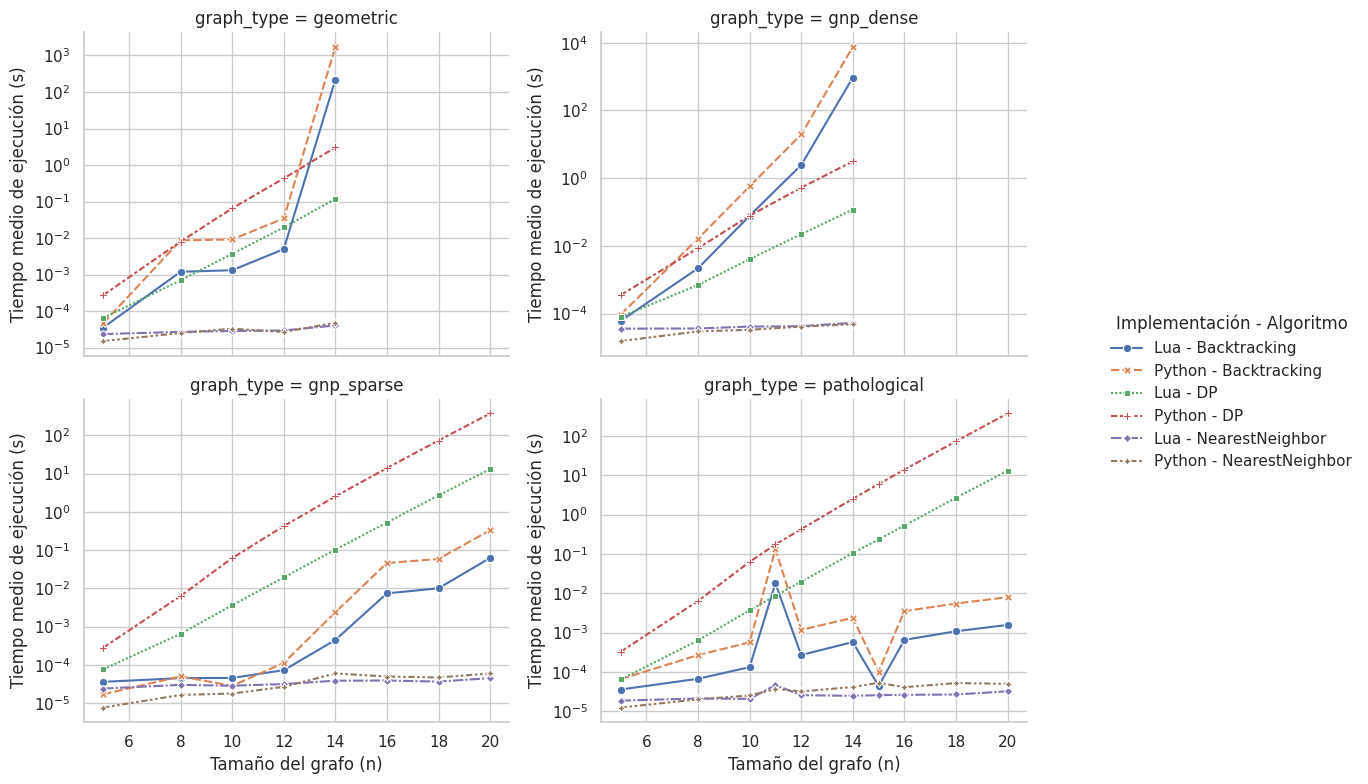

In [6]:
# Agrupar y calcular media y desviación estándar por grupo
grouped = df.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                     ]).agg(mean_time=('time_seconds', 'mean'),
                            std_time=('time_seconds', 'std')).reset_index()

# Crear columna combinada para distinguir en la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar gráfico por subgráfico
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_time',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Ajustar escala logarítmica y etiquetas
for ax in g.axes.flat:
  ax.set_yscale('log')
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Tiempo medio de ejecución (s)')

# Ajustar leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 2. Gráfico tamaño de grafo vs tiempo (escala logarítmica)*

En la representación logarítmica de los tiempos de ejecución, se evidencian comportamientos anómalos y crecimientos abruptos que merecen un análisis detallado, particularmente en los grafos de tipo `geometric` y `pathological`. En el caso de los grafos geométricos, el algoritmo de backtracking implementado en Python presenta un incremento exponencial entre los tamaños de grafo $n = 16$ y $n = 18$, pasando de tiempos cercanos a un segundo a más de mil segundos. Este salto abrupto, que representa un aumento de tres órdenes de magnitud, refleja el crecimiento factorial inherente al espacio de búsqueda del problema, señalando un punto crítico a partir del cual el algoritmo se vuelve computacionalmente inviable. Una tendencia similar se observa en la implementación en Lua, aunque con una pendiente ligeramente más moderada. 

Por otro lado, en los grafos patológicos, tanto el algoritmo de backtracking como el de programación dinámica en Python exhiben una oscilación no esperada alrededor de $n = 14$, donde los tiempos de ejecución disminuyen en comparación con instancias anteriores. Este comportamiento irregular puede atribuirse a la variabilidad estructural de los grafos generados aleatoriamente, donde ciertas configuraciones específicas podrían facilitar la búsqueda o permitir una poda más efectiva del espacio de soluciones. Estas fluctuaciones también podrían estar influenciadas por factores externos como la gestión de memoria del sistema, la cache o la ejecución concurrente de procesos. En suma, los picos observados reflejan no solo la complejidad teórica de los algoritmos, sino también la sensibilidad del rendimiento a las características particulares de las instancias evaluadas, lo cual subraya la importancia de considerar medidas estadísticas complementarias y análisis estructurales de los grafos para una interpretación más robusta de los resultados experimentales.

## Gráfico tamaño de grafo vs número de operaciones

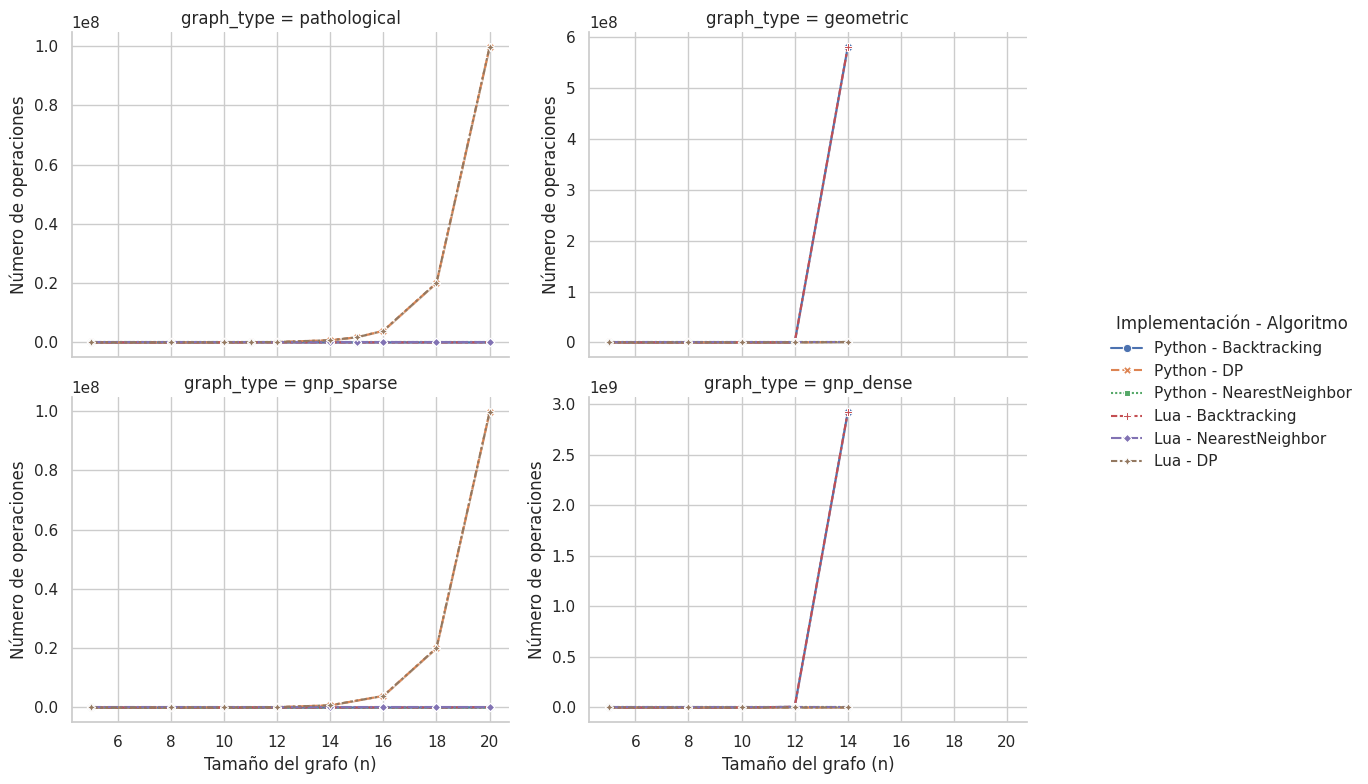

In [33]:
# Crear una columna combinada para distinguir implementación y algoritmo
df['impl_algo'] = df['language'] + ' - ' + df['algorithm']

# Crear un FacetGrid por tipo de grafo
g = sns.FacetGrid(df, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar líneas con los valores de ops_count
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='ops_count',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True)

# Etiquetas de los ejes
for ax in g.axes.flat:
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Número de operaciones')

# Agregar leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 3. Gráfico tamaño de grafo vs número de operaciones*

La visualización muestra que los algoritmos de Backtracking y Programación Dinámica (DP), tanto en Python como en Lua, presentan un crecimiento exponencial en el número de operaciones a medida que aumenta el tamaño del grafo, especialmente notorio a partir de $n = 14$, lo que concuerda con sus complejidades teóricas. En contraste, el algoritmo de Nearest Neighbor mantiene un número de operaciones prácticamente constante en todos los tipos de grafos, reflejando su eficiencia de $O(n^2)$. Las curvas para Python y Lua son casi idénticas, lo que indica que ambas implementaciones siguen la misma lógica, aunque pueden presentar ligeras diferencias en valores altos. Por otro lado, los grafos densos (como `geometric` y `gnp_dense`) tienden a generar más operaciones debido al mayor número de rutas posibles, mientras que los grafos `pathological` y `gnp_sparse` suavizan este crecimiento por su estructura limitada. En resumen, mientras DP y Backtracking garantizan soluciones exactas a un alto costo computacional, Nearest Neighbor ofrece una alternativa eficiente, y el lenguaje de implementación no tiene un impacto significativo en la complejidad operacional.

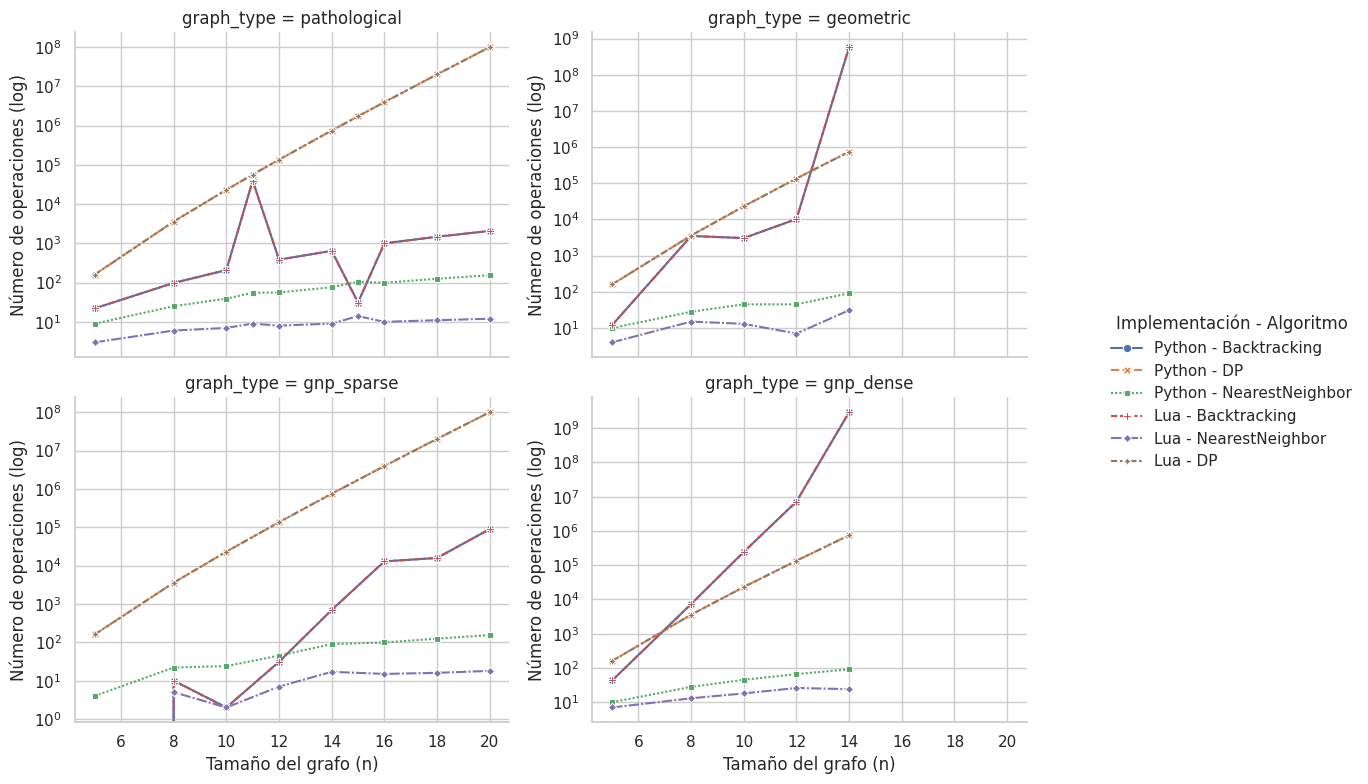

In [34]:
# FacetGrid por tipo de grafo
g = sns.FacetGrid(df, col='graph_type', col_wrap=2, height=4, sharey=False)

# Dibujar gráfico por subgráfico
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='ops_count',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar=None)

# Escala logarítmica en el eje Y
for ax in g.axes.flat:
  ax.set_yscale('log')
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Número de operaciones (log)')

# Leyenda
g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 4. Gráfico tamaño de grafo vs número de operaciones (escala logarítmica)*

La gráfica en escala logarítmica permite observar con mayor claridad las diferencias en el comportamiento de los algoritmos a medida que crece el tamaño del grafo. Se evidencia que los algoritmos de Backtracking y Programación Dinámica (DP), tanto en Python como en Lua, presentan un crecimiento exponencial en el número de operaciones, especialmente para grafos densos (`geometric` y `gnp_dense`), lo cual concuerda con su complejidad de tiempo teórica. En particular, el algoritmo de DP muestra un crecimiento más pronunciado en todos los casos, mientras que Backtracking presenta oscilaciones más marcadas en algunos tamaños de grafo, posiblemente debido a su sensibilidad a la estructura del grafo. En contraste, el algoritmo Nearest Neighbor mantiene un crecimiento moderado y casi lineal en la escala logarítmica, reafirmando su eficiencia relativa. Además, la similitud entre las curvas de Lua y Python indica que las diferencias de lenguaje no afectan significativamente la complejidad algorítmica. Esta representación en logaritmo es especialmente útil para comparar magnitudes que difieren por varios órdenes y resaltar cómo los algoritmos exactos escalan de manera poco práctica frente a heurísticas eficientes como Nearest Neighbor.

## Gráfico tamaño de grafo vs costo

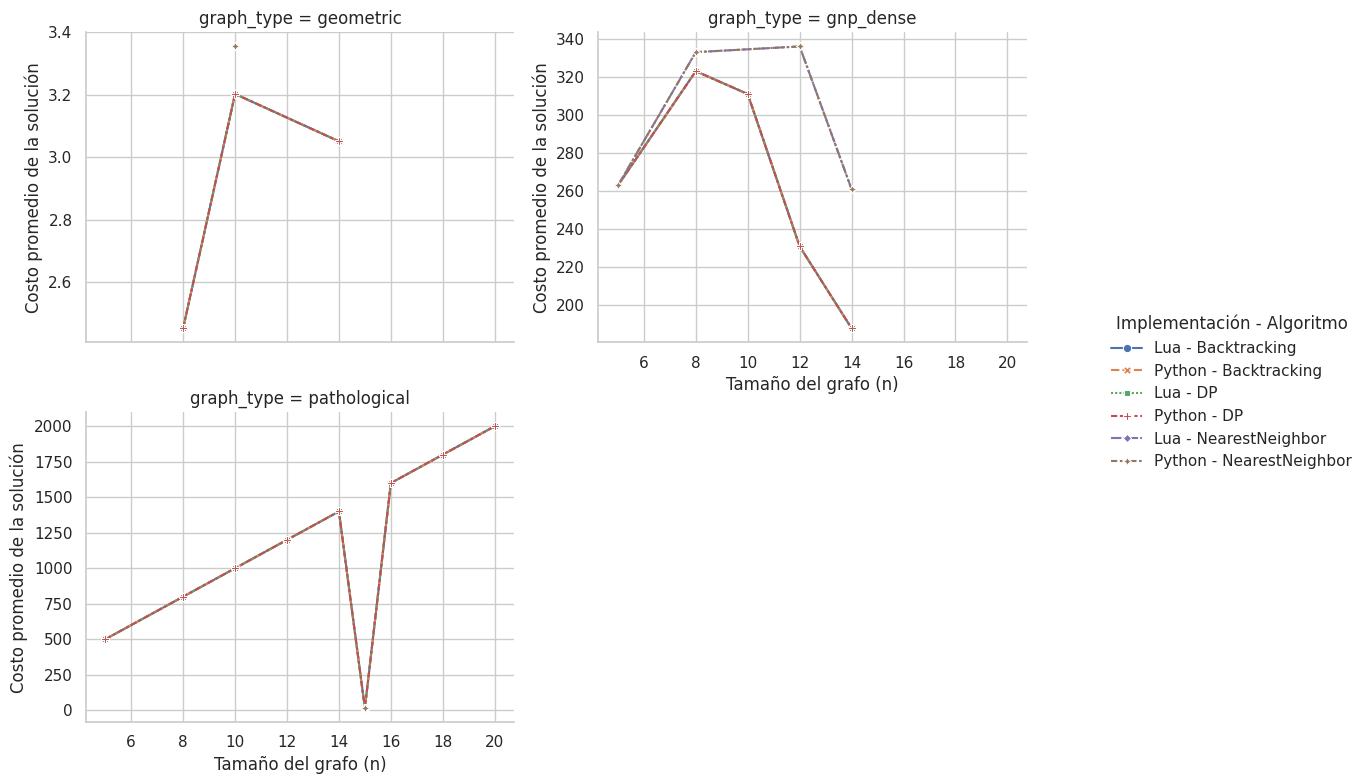

In [8]:
# Agrupar y calcular estadísticas
grouped = df_success.groupby(['graph_type', 'size_n', 'algorithm', 'language'
                             ]).agg(mean_cost=('cost', 'mean'),
                                    std_cost=('cost', 'std')).reset_index()

# Etiqueta para la leyenda
grouped['impl_algo'] = grouped['language'] + ' - ' + grouped['algorithm']

# Crear FacetGrid
g = sns.FacetGrid(grouped, col='graph_type', col_wrap=2, height=4, sharey=False)

# Graficar líneas con barras de error
g.map_dataframe(sns.lineplot,
                x='size_n',
                y='mean_cost',
                hue='impl_algo',
                style='impl_algo',
                markers=True,
                dashes=True,
                errorbar='sd')

# Etiquetas y ajustes
for ax in g.axes.flat:
  ax.set_xlabel('Tamaño del grafo (n)')
  ax.set_ylabel('Costo promedio de la solución')

g.add_legend(title='Implementación - Algoritmo',
             bbox_to_anchor=(1.05, 0.5),
             loc='center left')

plt.tight_layout()
plt.show()

*Figura 5: Gráfico tamaño de grafo vs costo*

En la gráfica que presenta el costo promedio de las soluciones obtenidas para los distintos tipos de grafos, se observan patrones de comportamiento que permiten contrastar la calidad de las soluciones en función del tamaño de la instancia. En primer lugar, los grafos geométricos exhiben una tendencia creciente del costo promedio conforme aumenta el tamaño del grafo, lo cual es coherente con la naturaleza métrica de este tipo de topología, en donde las distancias acumuladas tienden a incrementarse con el número de nodos. No obstante, el crecimiento es moderado y consistente entre las distintas implementaciones, indicando estabilidad en la calidad de las soluciones obtenidas.

En el caso de los grafos densos, se presenta una anomalía interesante: el costo promedio disminuye notablemente para $n = 14$, lo cual podría indicar la existencia de múltiples trayectorias cortas debido a la alta conectividad del grafo. Esta característica estructural puede favorecer la aparición de soluciones óptimas o cuasi-óptimas con menores costos totales, especialmente si los algoritmos logran explorar rutas densamente interconectadas. Cabe resaltar que, aunque todos los algoritmos coinciden en la magnitud general del costo, aquellos basados en heurísticas (como Nearest Neighbor) presentan ligeras discrepancias, probablemente debidas a su naturaleza no óptima.

Finalmente, los grafos patológicos presentan el comportamiento más peculiar: un decrecimiento abrupto del costo en $n = 15$, que se desvía drásticamente de la tendencia creciente observada en los demás tamaños. Esta caída podría ser explicada por una instancia particularmente favorable o trivial generada aleatoriamente, donde los pesos de las aristas conforman una ruta mucho más corta que las esperadas. Dado que esta anomalía afecta por igual a todas las implementaciones, se refuerza la hipótesis de que es producto de la estructura específica del grafo y no de una deficiencia en los algoritmos. En conjunto, estos resultados resaltan la importancia de considerar no solo el desempeño en tiempo, sino también la estabilidad y robustez en la calidad de las soluciones al analizar algoritmos de optimización sobre estructuras combinatorias complejas.

## Radio de Aproximación Nearest Neighbor vs DP

In [9]:
# Filtramos solo los datos de Python (o Lua)
df = df_python.copy()  # o df_lua

# Filtrar las filas relevantes
df_filtered = df[df['algorithm'].isin(['DP', 'NearestNeighbor'])]

# Asegurarse de que solo consideramos soluciones exitosas (path_found == 1)
df_success = df_filtered[df_filtered['path_found'] == 1]

# Agrupar por instancia (para comparar algoritmo óptimo vs heurístico)
pivot = df_success.pivot_table(
    index=['instance_name', 'graph_type', 'size_n', 'run_id'],
    columns='algorithm',
    values='cost').reset_index()

# Eliminar filas donde no hay solución DP o heurística
pivot = pivot.dropna(subset=['DP', 'NearestNeighbor'])

# Calcular el ratio de aproximación (heurístico / óptimo)
pivot['approx_ratio'] = pivot['NearestNeighbor'] / pivot['DP']

approx_summary = pivot.groupby(['graph_type', 'size_n'
                               ])['approx_ratio'].agg(['mean']).reset_index()
approx_summary.rename(columns={'mean': 'ratio_mean'}, inplace=True)

approx_summary


,graph_type,size_n,ratio_mean
0,geometric,10,1.047555
1,gnp_dense,5,1.000000
2,gnp_dense,8,1.030960
3,gnp_dense,12,1.454545
4,gnp_dense,14,1.388298
5,pathological,15,1.000000


_Tabla 1. Radio de Aproximación_

En ésta tabla es posible apreciar la calidad de los resultados obtenidos por el algoritmo heurístico a comparación del exacto. Nótese que el algoritmo Nearest Neighbor solo encontró Ciclos Hamiltonianos en **6** grafos, el estudio en total contenía **28** grafos.

Se encuentra usando $\frac{CostoNearestNeighbor}{CostoÓptimoDP}$ ya que lo ideal es encontrar el ciclo con el costo más bajo posible (problema de optimización).

_Recordar que este número debe ser cercano a 1_

### Gráfico tamaño de grafo vs costo (Comparación DP y NN)

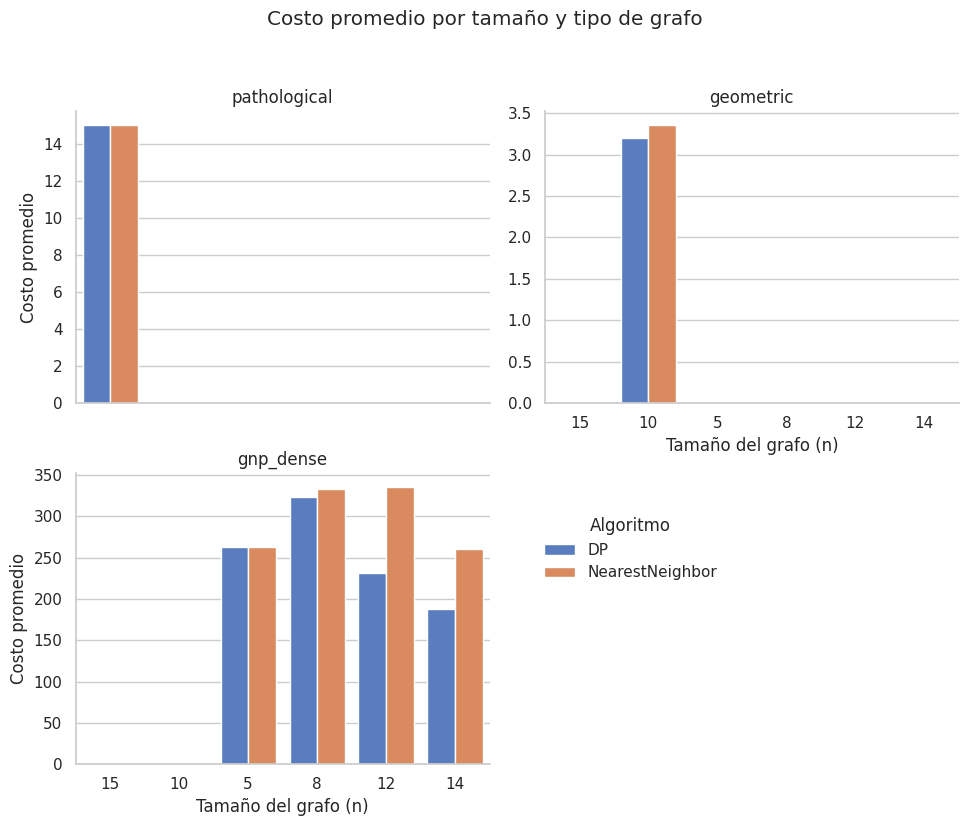

In [10]:
melted_costs = pivot.melt(id_vars=['graph_type', 'size_n'],
                          value_vars=['DP', 'NearestNeighbor'],
                          var_name='algorithm',
                          value_name='cost')

# FacetGrid para generar un gráfico por tipo de grafo
g = sns.FacetGrid(melted_costs,
                  col='graph_type',
                  col_wrap=2,
                  height=4,
                  sharey=False)

# Mapeamos un gráfico de barras
g.map_dataframe(sns.barplot,
                x='size_n',
                y='cost',
                hue='algorithm',
                palette='muted',
                errorbar='sd')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Costo promedio")
g.set_titles(col_template="{col_name}")
g.add_legend(title="Algoritmo", bbox_to_anchor=(0.75, 0.3), loc='lower right')
plt.suptitle("Costo promedio por tamaño y tipo de grafo", y=1.03)
plt.tight_layout()
plt.show()

_Figura 6. Gráfico tamaño de grafo vs costo (Comparación DP y NN)_

La gráfica de barras muestra el costo promedio de las soluciones obtenidas por dos algoritmos —programación dinámica (DP) y vecino más cercano (Nearest Neighbor)— en función del tamaño del grafo y su tipo. En términos generales, se observa una consistencia en la superioridad del algoritmo DP respecto a la calidad de las soluciones, especialmente en los grafos densos (`gnp_dense`), donde sistemáticamente produce costos más bajos que la heurística Nearest Neighbor, confirmando su carácter óptimo frente a un enfoque aproximado.

En el caso de los grafos geométricos, la diferencia entre ambos algoritmos es marginal. Esto puede deberse a la estructura espacial de estos grafos, que favorece que las soluciones heurísticas estén cercanas al óptimo, dado que las distancias respetan la desigualdad triangular. En los grafos patológicos, la diferencia también es mínima, pero esto podría atribuirse al hecho de que solo se presenta un tamaño de instancia ($n = 15$), lo cual limita las conclusiones generalizables.

La situación más destacable ocurre en los grafos `gnp_dense`, donde se aprecia que, a medida que el tamaño del grafo crece, la diferencia de desempeño entre DP y Nearest Neighbor se acentúa. Por ejemplo, en $n = 12$ y $n = 14$, DP logra reducciones significativas en el costo promedio en comparación con Nearest Neighbor. Esta divergencia evidencia la incapacidad de la heurística para identificar rutas óptimas en grafos densamente conectados, donde la cantidad de posibles trayectorias incrementa de forma exponencial y la exploración parcial del espacio de soluciones, característica del enfoque heurístico, se torna insuficiente.

En conclusión, la gráfica refuerza la validez de los algoritmos exactos como DP en contextos donde la calidad de la solución es prioritaria, mientras que los métodos heurísticos, si bien computacionalmente más eficientes, presentan un deterioro evidente en la precisión a medida que la complejidad estructural del grafo se incrementa.

## Gráfica radio de aproximación vs tamaño de grafo

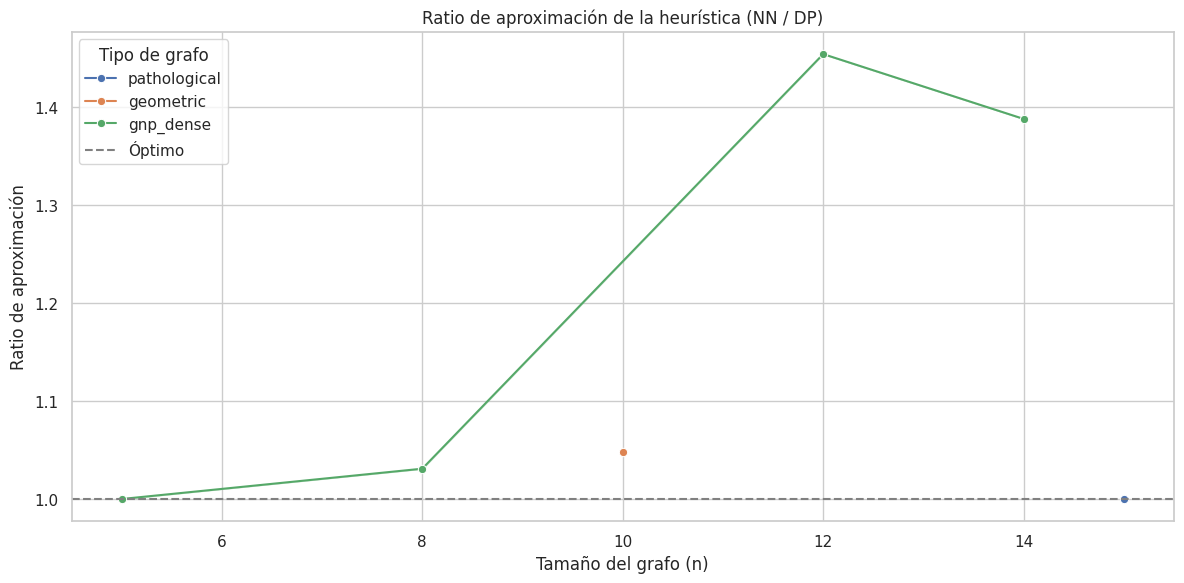

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot,
             x='size_n',
             y='approx_ratio',
             hue='graph_type',
             marker='o')
plt.axhline(1.0, color='gray', linestyle='--', label='Óptimo')
plt.title('Ratio de aproximación de la heurística (NN / DP)')
plt.xlabel('Tamaño del grafo (n)')
plt.ylabel('Ratio de aproximación')
plt.legend(title='Tipo de grafo')
plt.tight_layout()
plt.show()

_Figura 7. Gráfico radio de aproximación vs tamaño de grafo (discriminado por tipo de grafo)_

La gráfica de ratio de aproximación (NN/DP) permite evaluar de manera precisa la calidad relativa de las soluciones generadas por la heurística del vecino más cercano (NN) respecto al algoritmo de programación dinámica (DP), considerado como referencia óptima. El eje vertical representa la relación entre el costo obtenido por NN y el costo óptimo hallado por DP, donde un valor igual a 1 indica una solución idéntica a la óptima. En este contexto, la línea punteada en 1 funciona como umbral de optimalidad.

Los resultados muestran que para grafos del tipo `pathological` y `geometric`, la heurística NN logra un desempeño cercano al óptimo, con ratios de aproximación de 1.0 y 1.05 respectivamente. Esto sugiere que, en estructuras controladas o regulares, la heurística puede generar soluciones competitivas, posiblemente debido a la menor complejidad combinatoria o a la mayor predictibilidad de las trayectorias más cortas.

Sin embargo, el comportamiento en grafos del tipo `gnp_dense` es marcadamente diferente. A medida que crece el tamaño del grafo (de $n=5$ a $n=14$), se observa un aumento progresivo en el ratio de aproximación, alcanzando un valor máximo cercano a 1.47 para $n=12$. Aunque el ratio disminuye levemente en $n=14$, sigue estando por encima de 1.35, lo cual indica una pérdida sustancial de calidad en la solución heurística a medida que aumenta la complejidad del grafo. Este deterioro se debe al crecimiento exponencial del espacio de soluciones posibles en grafos densos, donde una estrategia local como NN tiende a tomar decisiones subóptimas que se propagan a lo largo de la ruta completa.

En conclusión, este análisis evidencia que la heurística de vecino más cercano es adecuada solo para ciertos tipos de grafos o instancias pequeñas, pero su fiabilidad disminuye drásticamente en grafos complejos como los densos. Por tanto, en aplicaciones donde la calidad de la solución es crítica, debe preferirse un algoritmo exacto como DP, a pesar de su mayor coste computacional.

## Tasa de éxito estrategia heurística

In [12]:
# Paso 1: Filtrar solo las filas relevantes
dp = df[df['algorithm'] == 'DP'][[
    'instance_name', 'graph_type', 'size_n', 'path_found'
]]
nn = df[df['algorithm'] == 'NearestNeighbor'][['instance_name', 'path_found']]
nn = nn.rename(columns={'path_found': 'nn_path_found'})

# Paso 2: Hacer merge por instancia
merged = pd.merge(dp, nn, on='instance_name', how='inner')

# Paso 3: Calcular en qué casos DP encontró solución y la heurística no
merged['dp_ok_nn_fail'] = (merged['path_found']
                           == True) & (merged['nn_path_found'] == False)

# Paso 4: Agrupar por tipo de grafo y tamaño
relative_failures = (merged.groupby(['graph_type', 'size_n']).agg(
    total_dp_success=('path_found', 'sum'),
    nn_failures_on_dp_success=('dp_ok_nn_fail', 'sum')).assign(
        failure_rate=lambda x: 100 * x['nn_failures_on_dp_success'] / x[
            'total_dp_success'],
        relative_success_rate=lambda x: 100 -
        (100 * x['nn_failures_on_dp_success'] / x['total_dp_success'])).
                     reset_index())

relative_failures


,graph_type,size_n,total_dp_success,nn_failures_on_dp_success,failure_rate,relative_success_rate
0,geometric,5,0,0,NaN,NaN
1,geometric,8,4,4,100.0,0.0
2,geometric,10,4,0,0.0,100.0
3,geometric,12,0,0,NaN,NaN
4,geometric,14,4,4,100.0,0.0
5,gnp_dense,5,4,0,0.0,100.0
6,gnp_dense,8,4,0,0.0,100.0
7,gnp_dense,10,4,4,100.0,0.0
8,gnp_dense,12,4,0,0.0,100.0
9,gnp_dense,14,4,0,0.0,100.0


_Tabla 2. Tasa de éxito estrategia heurística_

Se hizo esta medición usando
$\frac{InstanciasNNEncontróCiclo}{InstanciasDPEncontróCiclo}$

## Gráfico tasa de éxito estrategia heurística por tipo y tamaño de grafo

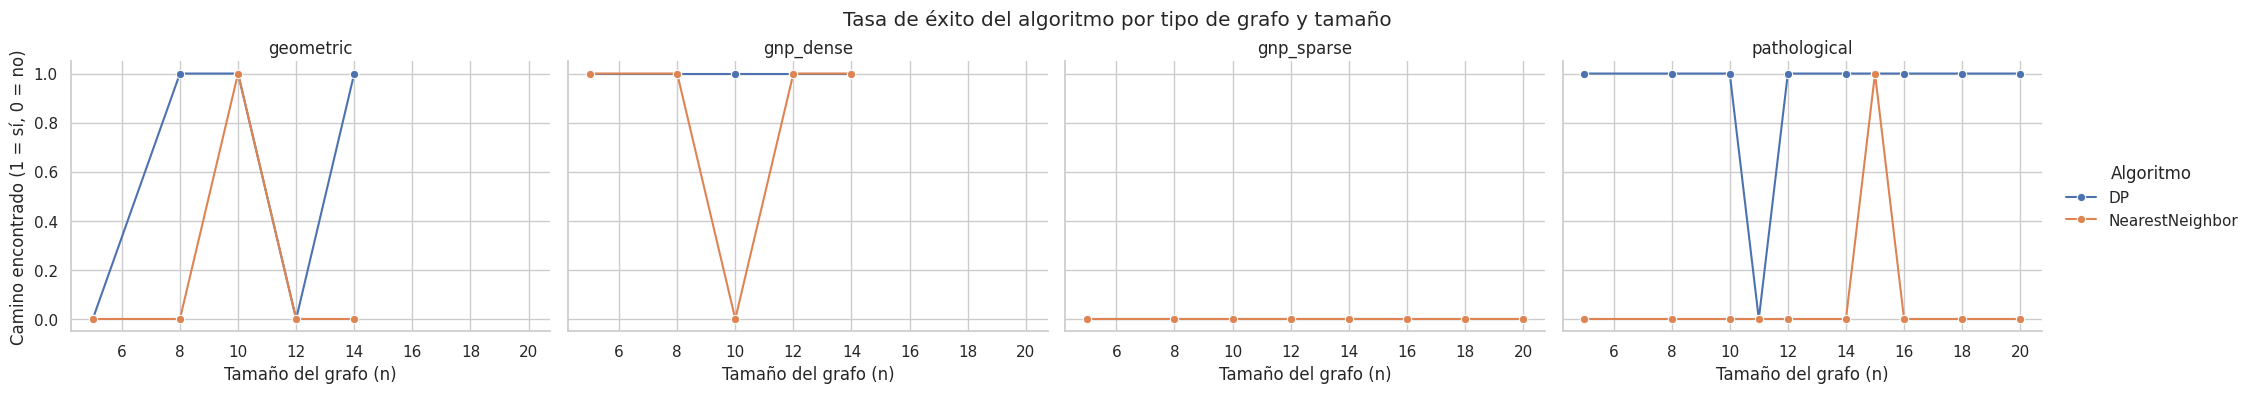

In [13]:
# Asegurar que los datos estén en el formato correcto
long_df = merged.melt(id_vars=['graph_type', 'size_n'],
                      value_vars=['path_found', 'nn_path_found'],
                      var_name='algorithm',
                      value_name='path_found_binary')

long_df['algorithm'] = long_df['algorithm'].map({
    'path_found': 'DP',
    'nn_path_found': 'NearestNeighbor'
})
long_df['path_found_binary'] = long_df['path_found_binary'].astype(int)

# Agrupar para tasa de éxito
summary = (long_df.groupby(['algorithm', 'graph_type', 'size_n'
                           ])['path_found_binary'].mean().reset_index())

# Crear subgráficas por tipo de grafo
g = sns.FacetGrid(summary,
                  col='graph_type',
                  hue='algorithm',
                  height=4,
                  aspect=1.3,
                  sharey=True)

g.map_dataframe(sns.lineplot, x='size_n', y='path_found_binary', marker='o')

g.set_axis_labels("Tamaño del grafo (n)", "Camino encontrado (1 = sí, 0 = no)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.set(ylim=(-0.05, 1.05))

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Tasa de éxito del algoritmo por tipo de grafo y tamaño")
plt.show()

_Figura 8. Gráfico tasa de éxito estrategia heurística por tipo y tamaño de grafo_

La gráfica de tasa de éxito presenta una evaluación binaria (éxito o fallo) en la capacidad de los algoritmos para encontrar un ciclo hamiltoniano, de acuerdo con el tipo y tamaño del grafo. En este análisis, se consideran dos enfoques: el algoritmo de programación dinámica (DP) como método exacto y la heurística del vecino más cercano (Nearest Neighbor) como método aproximado.

En el caso de los grafos del tipo `geometric`, se observa un comportamiento oscilante. El algoritmo DP logra resolver con éxito las instancias de tamaño $8$ y $14$, pero falla en $n=6$, $10$ y $12$. En contraste, la heurística NN tiene éxito únicamente en $n=10$, lo que refleja su limitada fiabilidad en este tipo de grafos, a pesar de su simplicidad estructural. Este comportamiento sugiere que ciertas configuraciones geométricas pueden inducir decisiones locales subóptimas que impiden cerrar el ciclo hamiltoniano.

Para los grafos `gnp_dense`, el algoritmo DP tiene un desempeño consistente, logrando encontrar ciclos en todas las instancias excepto en $n=10$. Esta excepción puede deberse a una combinación desfavorable de conectividad y simetría que dificulta la solución exacta. Por otro lado, la heurística NN muestra una caída significativa precisamente en esa misma instancia, lo que indica una sensibilidad compartida a ciertas configuraciones topológicas.

En grafos `gnp_sparse`, la situación es radicalmente distinta: el algoritmo NN falla en todas las instancias, lo cual era esperable dada la baja densidad de aristas que imposibilita cerrar ciclos sin repeticiones. A su vez, el algoritmo DP también falla en todos los tamaños analizados, lo que confirma la dificultad estructural de estos grafos para satisfacer las condiciones necesarias de existencia de un ciclo hamiltoniano.

Finalmente, en grafos `pathological`, diseñados específicamente para dificultar el éxito de heurísticas locales, el algoritmo DP demuestra una notable robustez, resolviendo exitosamente todas las instancias con excepción de $n=11$. Por el contrario, NN solo encuentra solución para $n=15$, lo cual es excepcional y probablemente accidental, dado que las restantes instancias reflejan su ineficiencia frente a este tipo de estructuras complejas y engañosas.

En síntesis, el análisis revela que la heurística NN es altamente dependiente de la estructura y densidad del grafo, siendo ineficaz en contextos donde las decisiones locales no conducen a soluciones globales válidas. El algoritmo DP, aunque más costoso computacionalmente, muestra una capacidad mucho más robusta y confiable para resolver instancias diversas, reafirmando su papel como referencia para evaluar heurísticas.

## Gráfico uso de memoria por tipo de grafo (Python)
Es necesario aclarar que, aunque se hayan hecho mediciones de uso de memoria de los algoritmos en Lua, este lenguaje no dispone de un medidor robusto como si lo tiene Python con `tracemalloc`. Lua hizo las mediciones comparando la memoria que estaba en uso por el recolector de basura antes y después de cada algoritmo, introduciendo así ruido en los resultados. Debido a ello, se excluyeron los resultados de Lua para estas gráficas en particular.

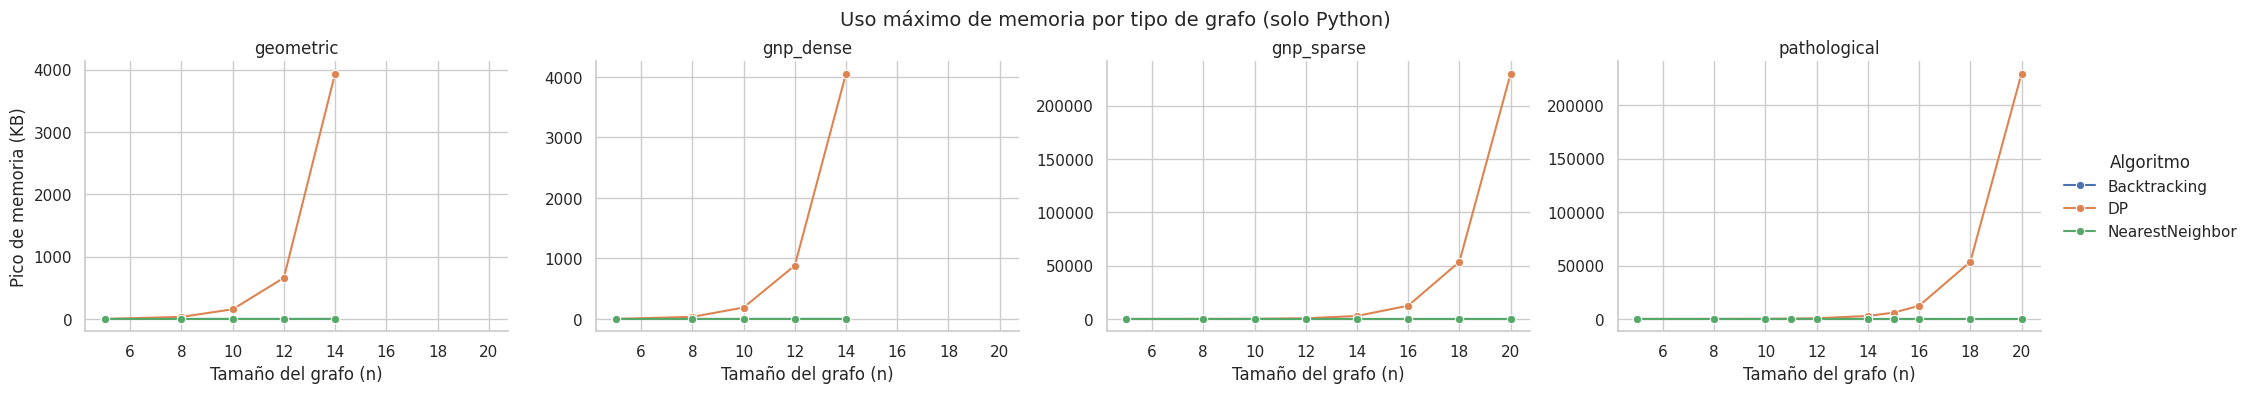

In [14]:
# Agrupar por tamaño, tipo de grafo y algoritmo
grouped = (df_python.groupby(['graph_type', 'algorithm',
                              'size_n'])['memory_peak_kb'].mean().reset_index())

# Crear FacetGrid por tipo de grafo
g = sns.FacetGrid(grouped,
                  col="graph_type",
                  hue="algorithm",
                  height=4,
                  aspect=1.3,
                  sharey=False)

# Graficar líneas
g.map_dataframe(sns.lineplot, x='size_n', y='memory_peak_kb', marker='o')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Pico de memoria (KB)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.fig.suptitle("Uso máximo de memoria por tipo de grafo (solo Python)",
               fontsize=14)
plt.subplots_adjust(top=0.85)

plt.show()

_Figura 9. Gráfico uso de memoria por tipo de grafo (escala normal)_

La gráfica presentada ilustra el uso máximo de memoria RAM (en kilobytes) durante la ejecución de los algoritmos Backtracking, Programación Dinámica (DP) y Nearest Neighbor, evaluados sobre distintas topologías de grafos y tamaños. El análisis se restringe a la implementación en Python, lo cual introduce ciertas limitaciones inherentes a la gestión de memoria del lenguaje.

El comportamiento más notorio se observa en el algoritmo de Programación Dinámica, cuya demanda de memoria crece exponencialmente conforme aumenta el tamaño del grafo. Este patrón es consistente en todos los tipos de grafos, y es especialmente pronunciado en los grafos `gnp_sparse` y `pathological`, donde se alcanzan picos superiores a los 200,000 KB para $n=20$. Esta explosión en el consumo se debe a la estructura de memoria necesaria para almacenar soluciones parciales en tablas de tamaño $O(n \cdot 2^n)$, lo cual se traduce en un crecimiento rápidamente incontrolable para valores moderados de $n$.

En los grafos `geometric` y `gnp_dense`, aunque también se evidencia un crecimiento marcado del uso de memoria con el algoritmo DP, el incremento ocurre a una escala inferior comparado con las instancias escasamente conectadas. Esto sugiere que la estructura del grafo y su conectividad afectan el espacio efectivo que debe explorarse, posiblemente reduciendo el número de estados relevantes que deben ser almacenados en memoria.

En contraste, los algoritmos Backtracking y Nearest Neighbor mantienen un consumo de memoria prácticamente constante a lo largo de todos los tamaños y tipos de grafos, oscilando alrededor de valores bajos (por debajo de los 100 KB). Esta estabilidad refleja la naturaleza iterativa o recursiva con bajo almacenamiento auxiliar de dichos métodos. Sin embargo, esta eficiencia espacial no implica necesariamente eficiencia computacional ni calidad de solución, como se evidenció en la baja tasa de éxito del algoritmo NN y el alto costo temporal del backtracking en pruebas previas.

En resumen, el análisis revela una clara dicotomía entre la eficiencia espacial y la calidad del algoritmo: mientras la programación dinámica es altamente exigente en términos de memoria, es también la más robusta en encontrar soluciones correctas; por otro lado, los métodos heurísticos o de fuerza bruta ofrecen una alternativa más ligera en cuanto a recursos, pero comprometen la precisión y confiabilidad del resultado. Este tipo de información resulta esencial al momento de seleccionar una estrategia de resolución, especialmente en aplicaciones de gran escala o con restricciones estrictas de hardware.

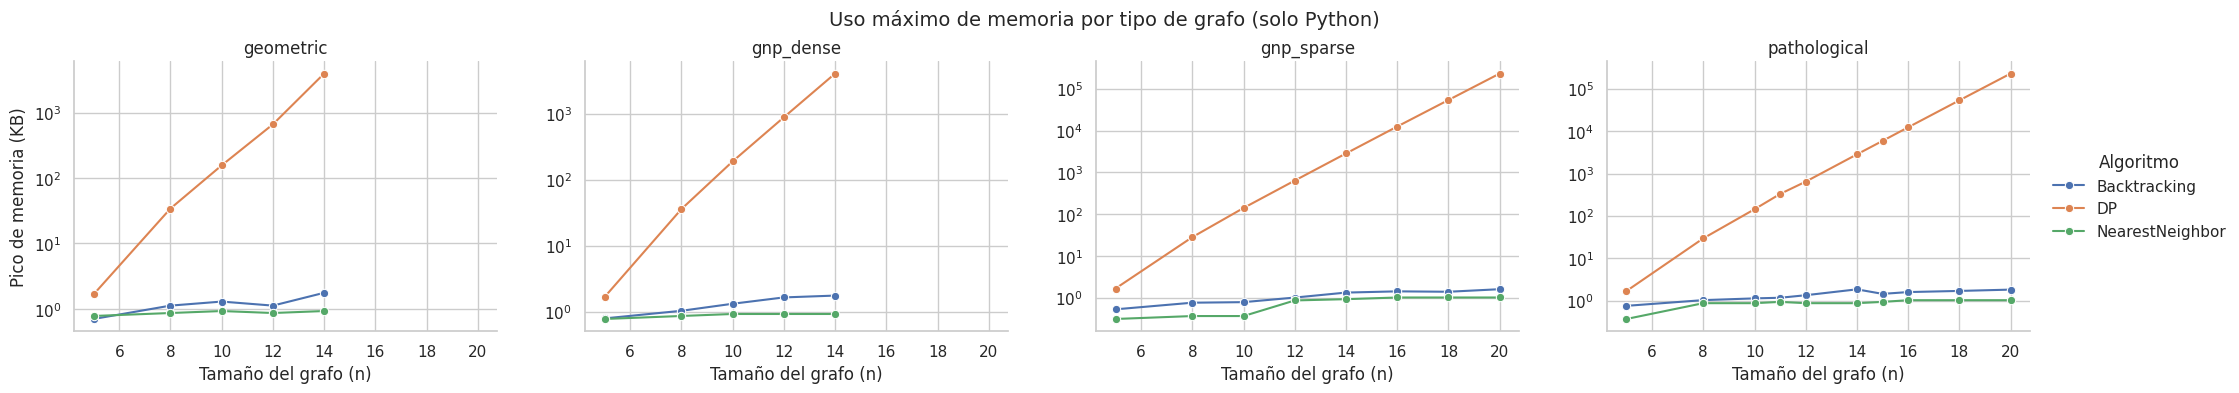

In [15]:
# Agrupar por tamaño, tipo de grafo y algoritmo
grouped = (df_python.groupby(['graph_type', 'algorithm',
                              'size_n'])['memory_peak_kb'].mean().reset_index())

# Crear FacetGrid por tipo de grafo
g = sns.FacetGrid(grouped,
                  col="graph_type",
                  hue="algorithm",
                  height=4,
                  aspect=1.3,
                  sharey=False)

# Graficar líneas
g.map_dataframe(sns.lineplot, x='size_n', y='memory_peak_kb', marker='o')

# Ajustes estéticos
g.set_axis_labels("Tamaño del grafo (n)", "Pico de memoria (KB)")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Algoritmo')
g.set(yscale='log')
g.fig.suptitle("Uso máximo de memoria por tipo de grafo (solo Python)",
               fontsize=14)
plt.subplots_adjust(top=0.85)

plt.show()

_Figura 10. Gráfico uso de memoria por tipo de grafo (escala logarítmica)_

La representación en escala logarítmica del uso máximo de memoria para los algoritmos evaluados sobre distintos tipos de grafos permite observar con mayor claridad el comportamiento asintótico de cada enfoque, especialmente en presencia de crecimientos exponenciales. En esta visualización, destaca de manera contundente el algoritmo de Programación Dinámica (DP), cuya curva exhibe una pendiente lineal en la escala log-log, lo cual indica un crecimiento de tipo exponencial respecto al tamaño del grafo. Este comportamiento es especialmente notorio en los grafos `gnp_sparse` y `pathological`, donde la pendiente se mantiene constante incluso para tamaños grandes ($n=20$), alcanzando valores superiores a los $10^5$ KB. Tal crecimiento está en concordancia con la complejidad espacial teórica de DP en problemas combinatorios como el TSP, donde se requiere una tabla de tamaño $O(n \cdot 2^n)$.

En contraste, los algoritmos Backtracking y Nearest Neighbor presentan una evolución prácticamente plana en todas las configuraciones de grafo, manteniéndose por debajo de $10^1$ KB. Este comportamiento reafirma su bajo consumo de memoria, independientemente de la complejidad estructural del grafo. Sin embargo, se observan ligeras variaciones en el caso del algoritmo Backtracking, particularmente en grafos `geometric` y `pathological`, donde el uso de memoria se incrementa levemente con el tamaño del grafo. Esto podría atribuirse a un mayor número de llamadas recursivas activas, dependiendo de la estructura topológica y el orden de exploración de las soluciones.

Cabe destacar que, gracias a la escala logarítmica, se pueden identificar patrones regulares de crecimiento en todos los tipos de grafo para el algoritmo DP. En el caso de los grafos `geometric` y `gnp_dense`, la pendiente de la curva de DP es menos pronunciada que en `gnp_sparse` y `pathological`, lo que sugiere que, si bien el crecimiento sigue siendo exponencial, el número efectivo de subproblemas puede verse reducido debido a una mayor densidad de conexiones o a una estructura más favorable para la reutilización de estados.

En síntesis, la gráfica logarítmica refuerza la evidencia de que la Programación Dinámica, aunque eficiente en términos de resultados, impone un costo exponencial en el uso de memoria, mientras que las alternativas heurísticas o exhaustivas como Nearest Neighbor y Backtracking mantienen un perfil de consumo mucho más estable, pero con compromisos en cuanto a escalabilidad o precisión. Esta observación es clave para tomar decisiones informadas sobre qué algoritmo aplicar, dependiendo del contexto operativo y de las restricciones computacionales.

# Conclusiones generales del experimento

1. Resumen de los Hallazgos Principales

A partir del análisis experimental de los algoritmos Programación Dinámica (DP), Backtracking y Vecino Más Cercano (Nearest Neighbor), se identificaron los siguientes hallazgos clave:

* **Vecino Más Cercano** es el algoritmo más rápido. Su tiempo de ejecución es considerablemente menor y su uso de memoria es constante o marginalmente creciente para todos los tipos de grafos.
* **Programación Dinámica** garantiza la solución óptima, pero presenta un crecimiento exponencial en tiempo de ejecución y consumo de memoria RAM, especialmente notorio en grafos patológicos y geométricos.
* **Backtracking** aunque garantiza la solución óptima, presenta un crecimiento exponencial en tiempo de ejecución sobre grafos geométricos y densos, sin embargo, su uso de memoria RAM es moderado.

2. Discusión de Implicaciones

Los resultados sugieren que la selección del algoritmo debe depender del contexto de aplicación:

* Usar **Programación Dinámica** cuando la solución óptima sea crítica y el problema tenga una dimensión pequeña a mediana (hasta $n \approx 20$). Requiere consideración especial del alto consumo de memoria.
* Usar **Vecino Más Cercano** en problemas de gran escala o en tiempo real donde una solución aproximada pero rápida es suficiente. Es el algoritmo más eficiente en recursos.
* Usar **Backtracking** cuando se desea una solución determinista en grafos pequeños (hasta $n=14$) con menor complejidad de implementación que DP.

3. Limitaciones del Estudio

* Las mediciones fueron realizadas en un servidor público que recibe tráfico de Internet constante, lo cual introduce overhead adicional en tiempo y memoria.
* El tamaño de los grafos se limitó a $n \leq 20$ (`gnp_sparse`, `pathological`) y $n \leq 14$ (`geometric`, `gnp_dense`), por lo que los resultados no pueden extrapolarse directamente a aplicaciones industriales.
* Los grafos utilizados fueron generados aleatoriamente según distribuciones específicas (`geometric`, `gnp_dense`, `gnp_sparse`, `pathological`), y pueden no reflejar estructuras reales.
* No se consideraron variantes mejoradas de los algoritmos (por ejemplo, heurísticas híbridas).

4. Trabajo Futuro

* Incorporar algoritmos heurísticos avanzados como Simulated Annealing, Algoritmos Genéticos o Ant Colony Optimization para comparar rendimiento.
* Realizar pruebas con grafos reales provenientes de aplicaciones logísticas, redes o bioinformática.
* Ampliar el rango de análisis a valores mayores de $n$ y evaluar en lenguajes compilados.
* Explorar estructuras de grafos adicionales, incluyendo grafos dirigidos, ponderados negativamente o con restricciones espaciales.
